In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax
from functools import partial
from typing import Callable

from history import History

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [2]:
from problems import Wave
problem = Wave()

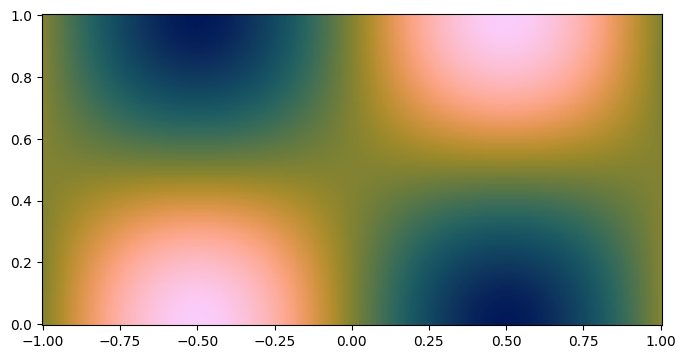

In [3]:
X, T, u_solution = problem.exact_solution(nx=256, nt=128)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax_exact = ax.pcolormesh(X, T, u_solution, cmap=cmap)

# Optimiser

In [4]:
from jax.flatten_util import ravel_pytree
from typing import Callable, Dict, Tuple


class Bfgs:
    """
    An iterative BFGS optimiser.

    This optimiser performs one step of the BFGS algorithm for each call to `update`.
    It approximates the inverse Hessian matrix and uses a backtracking line search
    to determine the step size, satisfying the Armijo condition.
    """

    def __init__(self, max_line_search_iter: int = 20):
        """
        Args:
            max_line_search_iter: The maximum number of backtracking steps for the
                                  line search at each update.
        """
        self.max_line_search_iter = max_line_search_iter

    def init(self, params: eqx.Module) -> optax.OptState:
        """
        Initialises the optimiser state.

        The state includes the initial inverse Hessian approximation (identity matrix),
        placeholders for the previous parameters and gradients, and a flag to
        handle the first optimisation step.
        """
        params_flat, _ = ravel_pytree(params)
        num_params = params_flat.shape[0]

        return {
            "inv_hessian": jnp.eye(num_params),
            "grad_prev": jnp.zeros_like(params_flat),
            "params_prev": params_flat,
            "is_first_step": True,
        }

    def update(
        self,
        params: eqx.Module,
        state: optax.OptState,
        residual_fn: Callable[[eqx.Module], jax.Array],
    ) -> Tuple[jnp.ndarray, eqx.Module, optax.OptState, Dict]:
        """Performs a single BFGS update step."""
        params_flat, unflatten = ravel_pytree(params)

        # The loss function for BFGS is the mean squared error of the residuals.
        def loss_fn(p_flat: jax.Array) -> jnp.ndarray:
            return jnp.mean(residual_fn(unflatten(p_flat)) ** 2)

        # 1. Compute current loss and gradient
        current_loss, current_grad = jax.value_and_grad(loss_fn)(params_flat)

        # 2. Update the inverse Hessian approximation (skipped on first step)
        s_k = params_flat - state["params_prev"]
        y_k = current_grad - state["grad_prev"]
        sy_dot = jnp.dot(s_k, y_k)
        
        # A numerically stable BFGS update formula for the inverse Hessian.
        # This update is only performed if the curvature condition (sy_dot > 0) holds.
        rho = 1.0 / sy_dot
        Hy = state["inv_hessian"] @ y_k
        yHy = jnp.dot(y_k, Hy)
        term1 = rho * (rho * yHy + 1) * jnp.outer(s_k, s_k)
        term2 = -rho * (jnp.outer(s_k, Hy) + jnp.outer(Hy, s_k))
        inv_hessian_next = state["inv_hessian"] + term1 + term2

        # Use the updated Hessian if the curvature condition is met and it's not the first step.
        # Otherwise, use the previous approximation (which is the identity matrix on step 1).
        inv_hessian = jax.lax.cond(
            jnp.logical_and(sy_dot > 1e-8, jnp.logical_not(state["is_first_step"])),
            lambda: inv_hessian_next,
            lambda: state["inv_hessian"],
        )

        # 3. Compute search direction (uses steepest descent for the first step)
        search_direction = -jnp.dot(inv_hessian, current_grad)

        # 4. Perform backtracking line search to find a suitable step size `alpha`
        # The goal is to satisfy the Armijo condition for sufficient decrease.
        def line_search_body(val):
            alpha, _, ls_count = val
            new_loss = loss_fn(params_flat + alpha * search_direction)
            # Armijo condition
            cond = new_loss <= current_loss + 1e-4 * alpha * jnp.dot(current_grad, search_direction)
            return alpha * 0.5, cond, ls_count + 1

        def line_search_cond(val):
            _, cond_satisfied, ls_count = val
            return jnp.logical_and(jnp.logical_not(cond_satisfied), ls_count < self.max_line_search_iter)

        # Initial step size alpha=1.0 is standard for quasi-Newton methods
        final_alpha, _, _ = jax.lax.while_loop(line_search_cond, line_search_body, (1.0, False, 0))
        
        # 5. Calculate parameter updates
        delta_flat = final_alpha * search_direction
        updates = unflatten(delta_flat)

        # 6. Prepare new state for the next iteration
        new_state = {
            "inv_hessian": inv_hessian,
            "grad_prev": current_grad,
            "params_prev": params_flat,
            "is_first_step": False,
        }
        
        # 7. Collect metrics for logging
        metrics = {
            "loss": current_loss,
            "gradient_norm": jnp.linalg.norm(current_grad),
            "step_size": final_alpha,
            "search_direction_norm": jnp.linalg.norm(search_direction),
        }

        return current_loss, updates, new_state, metrics
    

class StandardLevenbergMarquardt:
    """
    Standard Levenberg-Marquardt optimiser.
    """

    def __init__(
        self,
        init_lambda=1e-3,
        decrease_factor: float = 10,
        increase_factor: float = 2,
        max_trials: int = 200,
    ):
        self.init_lambda = init_lambda
        self.decrease_factor = decrease_factor
        self.increase_factor = increase_factor
        self.max_trials = max_trials

    def init(self, params: eqx.Module):
        """Initializes the optimizer state with the initial damping factor."""
        return {'lambda': self.init_lambda}

    def update(
        self,
        params: eqx.Module,
        state: optax.OptState,
        residual_fn: Callable[[eqx.Module], jax.Array]
    ):
        current_lambda = state['lambda']
        params_flat, unflatten = jax.flatten_util.ravel_pytree(params)

        def flat_residual_fn(p_flat):
            return residual_fn(unflatten(p_flat))

        residuals = residual_fn(params)
        current_loss = jnp.mean(residuals**2)

        J = jax.jacfwd(flat_residual_fn)(params_flat)
        U, S, Vt = jnp.linalg.svd(J, full_matrices=False)

        def evaluate_trial_step(loop_val):
            trial_lambda, _, trial_count = loop_val
            
            delta = -Vt.T @ jnp.diag(S / (S**2 + trial_lambda)) @ U.T @ residuals

            trial_params = eqx.apply_updates(params, unflatten(delta))
            trial_residuals = residual_fn(trial_params)
            trial_loss = jnp.mean(trial_residuals**2)
            
            accepted = trial_loss < current_loss
            
            new_lambda = jax.lax.cond(
                accepted,
                lambda: trial_lambda / self.decrease_factor,
                lambda: trial_lambda * self.increase_factor
            )
            
            return new_lambda, accepted, trial_count + 1

        def continue_until_accepted(loop_val):
            # Continue if step is not accepted AND we haven't exceeded max trials
            _, accepted, trial_count = loop_val
            return jnp.logical_and(jnp.logical_not(accepted), trial_count < self.max_trials)

        # --- Run the loop to find an acceptable step and lambda ---
        final_lambda, step_was_accepted, _ = jax.lax.while_loop(
            continue_until_accepted, evaluate_trial_step, (current_lambda, False, 0)
        )

        final_delta = -Vt.T @ jnp.diag(S / (S**2 + (final_lambda * self.decrease_factor))) @ U.T @ residuals
        
        updates = unflatten(final_delta)
        new_state = {'lambda': final_lambda}

        metrics = { 
            'loss': current_loss,
            'singular_values': S,
            'search_direction_norm': jnp.linalg.norm(final_delta),
            'lambda': final_lambda * self.decrease_factor,
        }

        return current_loss, updates, new_state, metrics



@partial(jax.jit, static_argnums=(3, 4))
def train_step(params, static_parts, opt_state, optimiser, problem, collocation_points):
    def residual_fn_for_optimizer(p):
        rebuilt_model = eqx.combine(p, static_parts)
        return problem.physics_residual(problem.residual_fn, rebuilt_model, collocation_points, problem.c)

    loss, updates, new_opt_state, metrics = optimiser.update(params, opt_state, residual_fn_for_optimizer)
    new_params = eqx.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss, metrics

In [9]:
key = jax.random.PRNGKey(42)

# --- Hyperparameters ---
n_collocation_points = 2**11
layer_sizes = [2, 12, 12, 12, 12, 12, 12, 12, 12, 1]
# -----------------------

model_key, data_key = jax.random.split(key)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)
collocation_points = problem.get_collocation_points(n_collocation_points, seed=1)
history = History()


optimiser = Bfgs(
)

opt_state = optimiser.init(params)
print(f"Starting PINN training with {type(optimiser).__name__}...")
for epoch in range(2000):
    params, opt_state, loss_val, metrics = train_step(
        params, static, opt_state, optimiser, problem, collocation_points
    )
    history.record(metrics)
    
    if (epoch + 1) % 200 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item():.3e}")

optimiser = StandardLevenbergMarquardt(
)
opt_state = optimiser.init(params)
print(f"Starting PINN training with {type(optimiser).__name__}...")
for epoch in range(200):
    params, opt_state, loss_val, metrics = train_step(
        params, static, opt_state, optimiser, problem, collocation_points
    )
    history.record(metrics)
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item():.3e}")


model = eqx.combine(params, static)
print("Training complete.")

Starting PINN training with Bfgs...
Epoch 200, Loss: 1.180e-01
Epoch 400, Loss: 9.359e-03
Epoch 600, Loss: 1.020e-03
Epoch 800, Loss: 2.959e-04
Epoch 1000, Loss: 1.007e-04
Epoch 1200, Loss: 7.104e-05
Epoch 1400, Loss: 7.023e-05
Epoch 1600, Loss: 5.431e-05
Epoch 1800, Loss: 5.483e-05
Epoch 2000, Loss: 5.657e-05
Starting PINN training with StandardLevenbergMarquardt...
Epoch 20, Loss: 4.079e-05
Epoch 40, Loss: 3.478e-05
Epoch 60, Loss: 2.995e-05
Epoch 80, Loss: 2.502e-05
Epoch 100, Loss: 2.052e-05
Epoch 120, Loss: 1.633e-05
Epoch 140, Loss: 1.301e-05
Epoch 160, Loss: 1.076e-05
Epoch 180, Loss: 8.855e-06
Epoch 200, Loss: 7.327e-06
Training complete.


Relative L2 Error: 5.133e-01


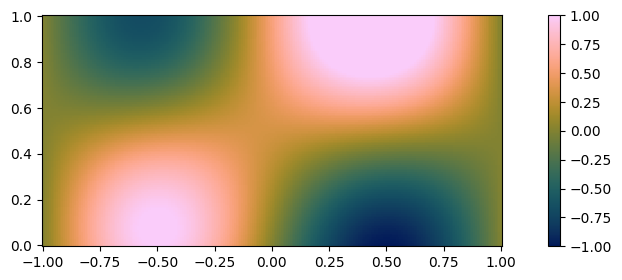

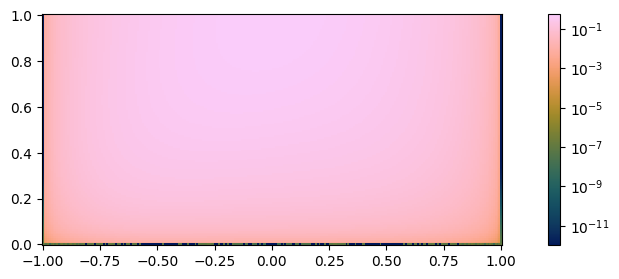

In [10]:
u_pred = model.predict(X, T)

error = jnp.abs(u_solution - u_pred)
rel_l2_error = jnp.linalg.norm(error) / jnp.linalg.norm(u_solution)

print(f"Relative L2 Error: {rel_l2_error:.3e}")

fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
nn_solution = ax.pcolormesh(X, T, u_pred, cmap=cmap, vmin=-1, vmax=1)
fig.colorbar(nn_solution, ax=ax, pad=0.05)
plt.show()

norm = colors.LogNorm(vmin=error.min() + 1e-12, vmax=error.max())
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
nn_error = ax.pcolormesh(X, T, np.abs(error) + 1e-12, norm=norm, cmap=cmap)
fig.colorbar(nn_error, ax=ax, pad=0.05)
plt.show()

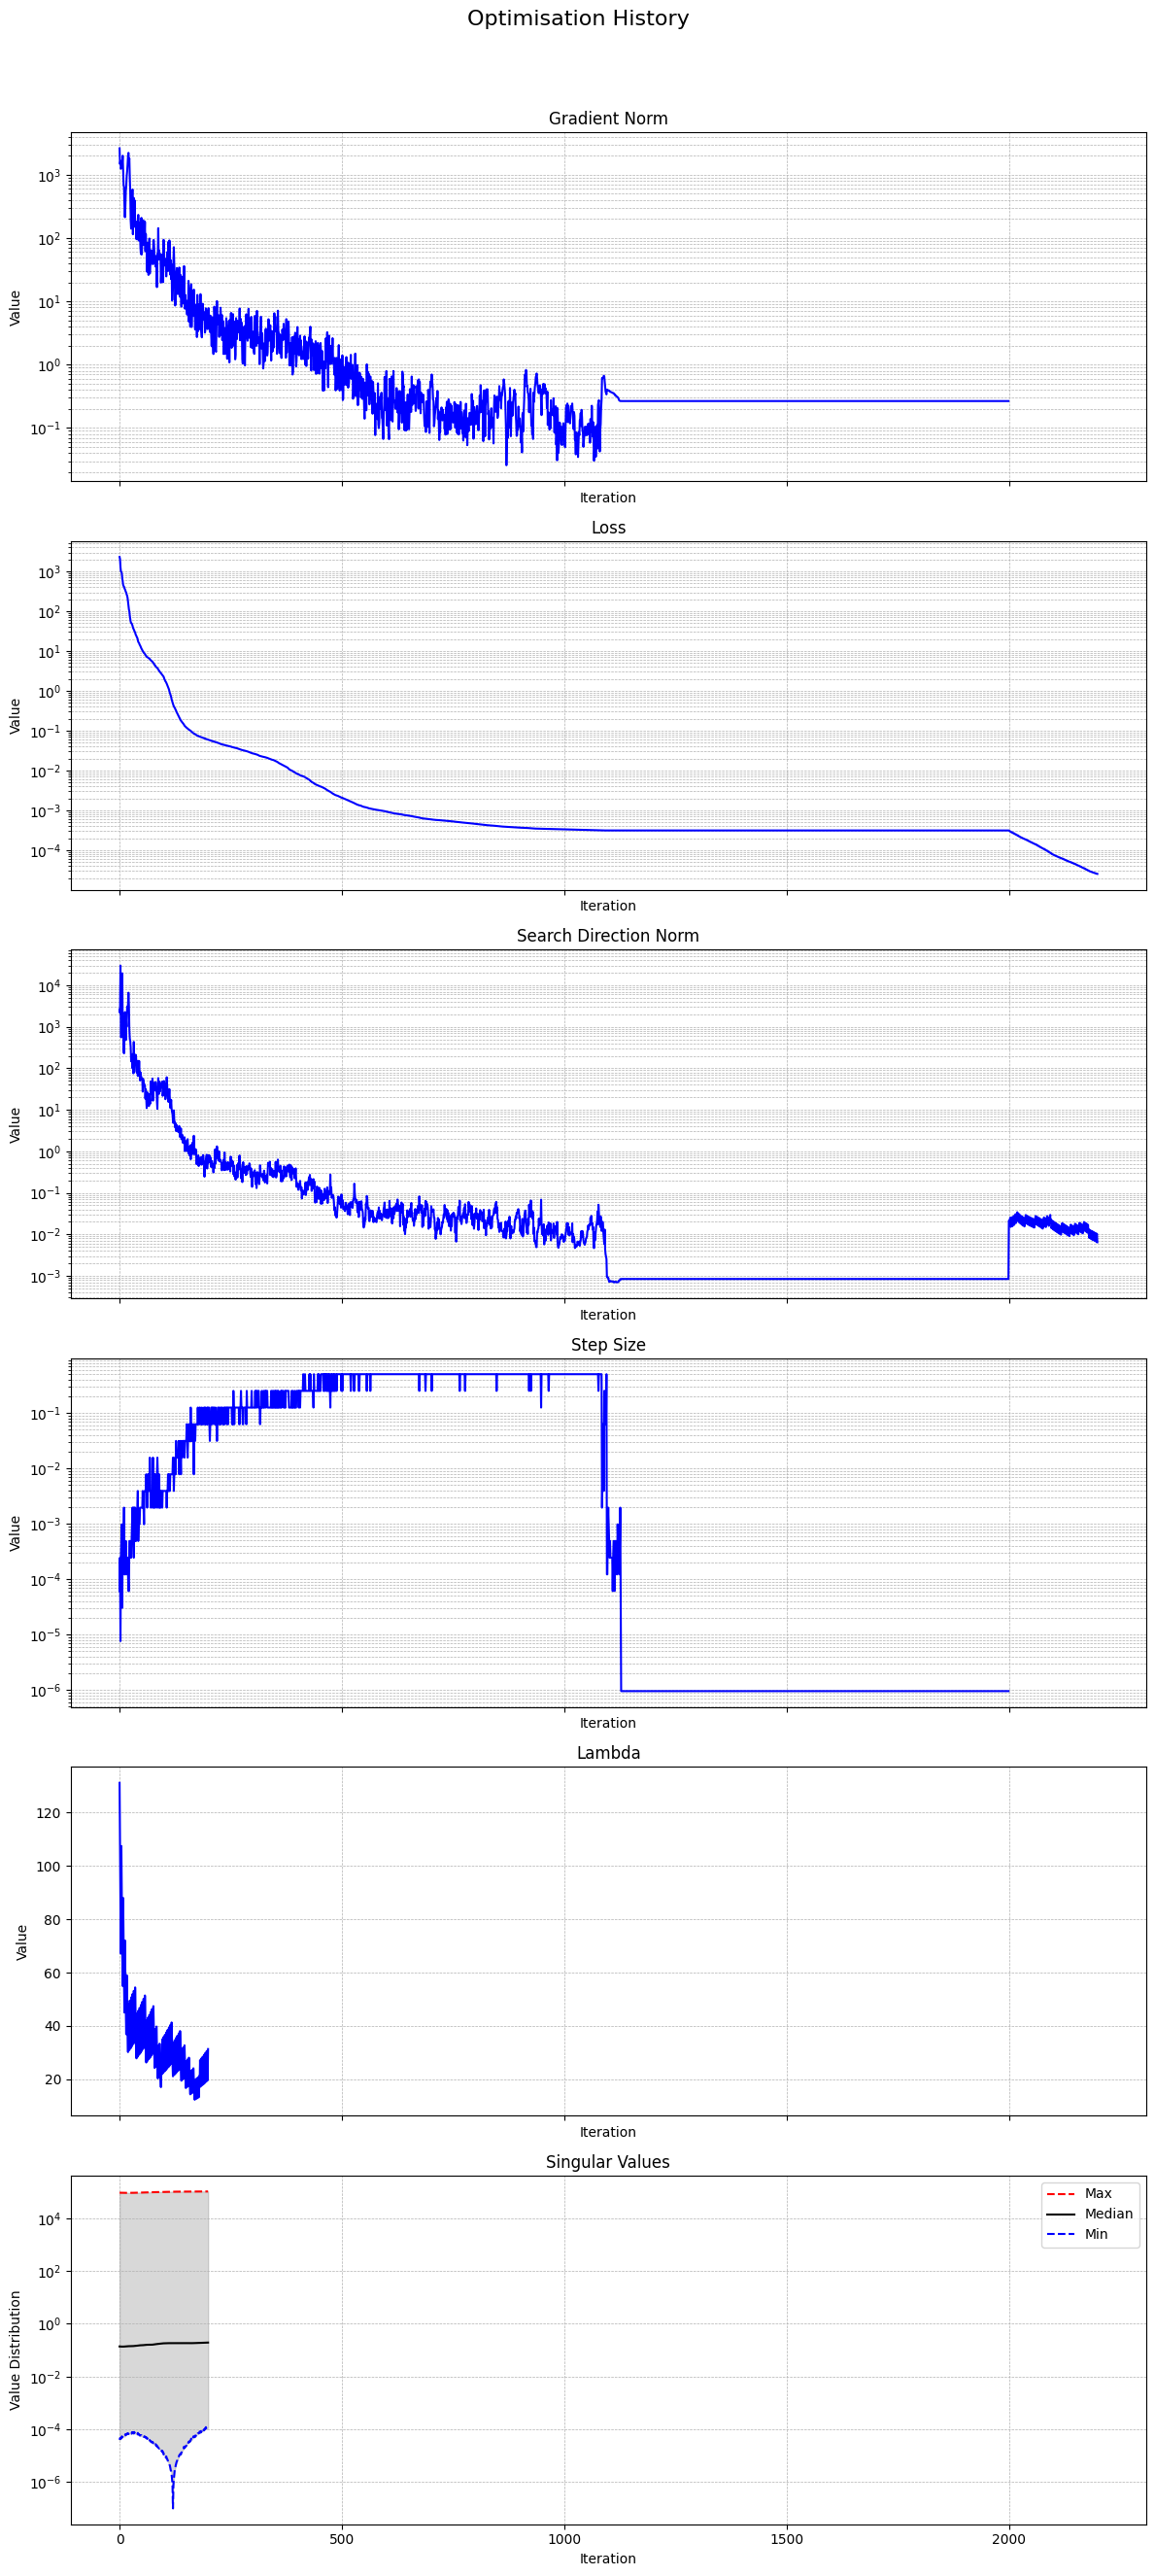

In [7]:
history.plot()